# Sciplex Dose

In [1]:
ood_seed = 13

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('SAHA', '100.0'), 419)


Removed datapoint: 419

train         11592
validation     2800
ood             419
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 59%|█████▉    | 8727/14811 [00:00<00:00, 87265.09it/s]

100%|██████████| 14811/14811 [00:00<00:00, 87153.07it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 905750.98it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 162.80it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:04<26:47,  4.03s/it]

Epoch 1/400:   0%|          | 1/400 [00:04<26:47,  4.03s/it, v_num=1, recon=3.07e+3, r2_mean=0.126, adv_loss=1.53, acc_pert=0.3]

Epoch 2/400:   0%|          | 1/400 [00:04<26:47,  4.03s/it, v_num=1, recon=3.07e+3, r2_mean=0.126, adv_loss=1.53, acc_pert=0.3]

Epoch 2/400:   0%|          | 2/400 [00:07<24:44,  3.73s/it, v_num=1, recon=3.07e+3, r2_mean=0.126, adv_loss=1.53, acc_pert=0.3]

Epoch 2/400:   0%|          | 2/400 [00:07<24:44,  3.73s/it, v_num=1, recon=2.33e+3, r2_mean=0.486, adv_loss=1.31, acc_pert=0.478]

Epoch 3/400:   0%|          | 2/400 [00:07<24:44,  3.73s/it, v_num=1, recon=2.33e+3, r2_mean=0.486, adv_loss=1.31, acc_pert=0.478]

Epoch 3/400:   1%|          | 3/400 [00:11<25:44,  3.89s/it, v_num=1, recon=2.33e+3, r2_mean=0.486, adv_loss=1.31, acc_pert=0.478]

Epoch 3/400:   1%|          | 3/400 [00:11<25:44,  3.89s/it, v_num=1, recon=2.18e+3, r2_mean=0.608, adv_loss=1.17, acc_pert=0.56] 

Epoch 4/400:   1%|          | 3/400 [00:11<25:44,  3.89s/it, v_num=1, recon=2.18e+3, r2_mean=0.608, adv_loss=1.17, acc_pert=0.56]

Epoch 4/400:   1%|          | 4/400 [00:15<26:09,  3.96s/it, v_num=1, recon=2.18e+3, r2_mean=0.608, adv_loss=1.17, acc_pert=0.56]

Epoch 4/400:   1%|          | 4/400 [00:15<26:09,  3.96s/it, v_num=1, recon=2.14e+3, r2_mean=0.681, adv_loss=1.07, acc_pert=0.599]

Epoch 5/400:   1%|          | 4/400 [00:15<26:09,  3.96s/it, v_num=1, recon=2.14e+3, r2_mean=0.681, adv_loss=1.07, acc_pert=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:19<24:55,  3.79s/it, v_num=1, recon=2.14e+3, r2_mean=0.681, adv_loss=1.07, acc_pert=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:19<24:55,  3.79s/it, v_num=1, recon=2.12e+3, r2_mean=0.721, adv_loss=0.992, acc_pert=0.634]

Epoch 6/400:   1%|▏         | 5/400 [00:19<24:55,  3.79s/it, v_num=1, recon=2.12e+3, r2_mean=0.721, adv_loss=0.992, acc_pert=0.634]

Epoch 6/400:   2%|▏         | 6/400 [00:22<23:55,  3.64s/it, v_num=1, recon=2.12e+3, r2_mean=0.721, adv_loss=0.992, acc_pert=0.634]

Epoch 6/400:   2%|▏         | 6/400 [00:22<23:55,  3.64s/it, v_num=1, recon=2.11e+3, r2_mean=0.749, adv_loss=0.946, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 6/400 [00:22<23:55,  3.64s/it, v_num=1, recon=2.11e+3, r2_mean=0.749, adv_loss=0.946, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 7/400 [00:26<23:38,  3.61s/it, v_num=1, recon=2.11e+3, r2_mean=0.749, adv_loss=0.946, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 7/400 [00:26<23:38,  3.61s/it, v_num=1, recon=2.1e+3, r2_mean=0.771, adv_loss=0.916, acc_pert=0.665] 

Epoch 8/400:   2%|▏         | 7/400 [00:26<23:38,  3.61s/it, v_num=1, recon=2.1e+3, r2_mean=0.771, adv_loss=0.916, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:29<23:53,  3.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.771, adv_loss=0.916, acc_pert=0.665]

Epoch 8/400:   2%|▏         | 8/400 [00:29<23:53,  3.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.789, adv_loss=0.892, acc_pert=0.676]

Epoch 9/400:   2%|▏         | 8/400 [00:29<23:53,  3.66s/it, v_num=1, recon=2.1e+3, r2_mean=0.789, adv_loss=0.892, acc_pert=0.676]

Epoch 9/400:   2%|▏         | 9/400 [00:33<24:38,  3.78s/it, v_num=1, recon=2.1e+3, r2_mean=0.789, adv_loss=0.892, acc_pert=0.676]

Epoch 9/400:   2%|▏         | 9/400 [00:33<24:38,  3.78s/it, v_num=1, recon=2.09e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.681]

Epoch 10/400:   2%|▏         | 9/400 [00:33<24:38,  3.78s/it, v_num=1, recon=2.09e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.681]


disnt_basal = 0.4134455896037928

disnt_after = 0.41640021123545395

val_r2_mean = 0.8166864243420687

val_r2_var = 0.2982755986126986


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:45<39:42,  6.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.681]

Epoch 10/400:   2%|▎         | 10/400 [00:45<39:42,  6.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.851, acc_pert=0.687, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:45<39:42,  6.11s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.851, acc_pert=0.687, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:49<35:13,  5.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.818, adv_loss=0.851, acc_pert=0.687, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:49<35:13,  5.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.829, adv_loss=0.842, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:49<35:13,  5.43s/it, v_num=1, recon=2.09e+3, r2_mean=0.829, adv_loss=0.842, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:52<31:08,  4.82s/it, v_num=1, recon=2.09e+3, r2_mean=0.829, adv_loss=0.842, acc_pert=0.697, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:52<31:08,  4.82s/it, v_num=1, recon=2.08e+3, r2_mean=0.84, adv_loss=0.838, acc_pert=0.696, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:52<31:08,  4.82s/it, v_num=1, recon=2.08e+3, r2_mean=0.84, adv_loss=0.838, acc_pert=0.696, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:55<28:15,  4.38s/it, v_num=1, recon=2.08e+3, r2_mean=0.84, adv_loss=0.838, acc_pert=0.696, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:55<28:15,  4.38s/it, v_num=1, recon=2.08e+3, r2_mean=0.845, adv_loss=0.826, acc_pert=0.699, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:55<28:15,  4.38s/it, v_num=1, recon=2.08e+3, r2_mean=0.845, adv_loss=0.826, acc_pert=0.699, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:59<27:09,  4.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.845, adv_loss=0.826, acc_pert=0.699, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:59<27:09,  4.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.819, acc_pert=0.707, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:59<27:09,  4.22s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.819, acc_pert=0.707, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:03<25:21,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.853, adv_loss=0.819, acc_pert=0.707, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:03<25:21,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.807, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:03<25:21,  3.95s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.807, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:06<24:25,  3.82s/it, v_num=1, recon=2.08e+3, r2_mean=0.862, adv_loss=0.807, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:06<24:25,  3.82s/it, v_num=1, recon=2.07e+3, r2_mean=0.865, adv_loss=0.812, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:06<24:25,  3.82s/it, v_num=1, recon=2.07e+3, r2_mean=0.865, adv_loss=0.812, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:10<23:54,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.865, adv_loss=0.812, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:10<23:54,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:10<23:54,  3.74s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:13<23:13,  3.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:13<23:13,  3.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.803, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:13<23:13,  3.65s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.803, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:18<24:49,  3.91s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.803, acc_pert=0.709, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:18<24:49,  3.91s/it, v_num=1, recon=2.07e+3, r2_mean=0.878, adv_loss=0.794, acc_pert=0.708, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:18<24:49,  3.91s/it, v_num=1, recon=2.07e+3, r2_mean=0.878, adv_loss=0.794, acc_pert=0.708, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]


disnt_basal = 0.436482547134384

disnt_after = 0.4389970271886741

val_r2_mean = 0.8733504728837449

val_r2_var = 0.35355978608131405


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:37<54:23,  8.59s/it, v_num=1, recon=2.07e+3, r2_mean=0.878, adv_loss=0.794, acc_pert=0.708, val_recon=2.08e+3, disnt_basal=0.413, disnt_after=0.416, val_r2_mean=0.817, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:37<54:23,  8.59s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:37<54:23,  8.59s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:41<44:25,  7.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.798, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:41<44:25,  7.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.784, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:41<44:25,  7.03s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.784, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:44<38:06,  6.05s/it, v_num=1, recon=2.06e+3, r2_mean=0.883, adv_loss=0.784, acc_pert=0.715, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:44<38:06,  6.05s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:44<38:06,  6.05s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:48<33:06,  5.27s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.71, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:48<33:06,  5.27s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.774, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:48<33:06,  5.27s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.774, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:51<29:28,  4.70s/it, v_num=1, recon=2.06e+3, r2_mean=0.885, adv_loss=0.774, acc_pert=0.719, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:51<29:28,  4.70s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.772, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:51<29:28,  4.70s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.772, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:54<26:53,  4.30s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.772, acc_pert=0.718, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:54<26:53,  4.30s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.769, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:54<26:53,  4.30s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.769, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:58<25:12,  4.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.769, acc_pert=0.717, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:58<25:12,  4.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.723, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:58<25:12,  4.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.723, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:01<24:16,  3.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.764, acc_pert=0.723, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:01<24:16,  3.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.762, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:01<24:16,  3.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.762, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:05<23:19,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.762, acc_pert=0.726, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:05<23:19,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [02:05<23:19,  3.76s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:08<22:49,  3.69s/it, v_num=1, recon=2.05e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:08<22:49,  3.69s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.753, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:08<22:49,  3.69s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.753, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]


disnt_basal = 0.44214332974432063

disnt_after = 0.44557032766156085

val_r2_mean = 0.8882915057919242

val_r2_var = 0.36452045223929663


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:18<34:32,  5.60s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.753, acc_pert=0.728, val_recon=2.06e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.873, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:18<34:32,  5.60s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]  

Epoch 31/400:   8%|▊         | 30/400 [02:18<34:32,  5.60s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<30:26,  4.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.751, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<30:26,  4.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.744, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:22<30:26,  4.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.744, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:26<28:35,  4.66s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.744, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:26<28:35,  4.66s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:26<28:35,  4.66s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:30<26:35,  4.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.74, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:30<26:35,  4.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.739, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:30<26:35,  4.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.739, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:33<25:13,  4.14s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.739, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:33<25:13,  4.14s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.735, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:33<25:13,  4.14s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.735, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:37<24:45,  4.07s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.735, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:37<24:45,  4.07s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [02:37<24:45,  4.07s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:40<23:28,  3.87s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.735, acc_pert=0.73, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:40<23:28,  3.87s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:41<23:28,  3.87s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:44<22:17,  3.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.734, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:44<22:17,  3.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:44<22:17,  3.68s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:47<21:57,  3.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.729, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:47<21:57,  3.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:47<21:57,  3.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:51<21:31,  3.58s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.726, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:51<21:31,  3.58s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.733, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:51<21:31,  3.58s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.733, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4426002385264194

disnt_after = 0.44565568252912696

val_r2_mean = 0.8925084336237474

val_r2_var = 0.3879756743257696


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:20<1:07:45, 11.29s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.733, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.888, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:20<1:07:45, 11.29s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:20<1:07:45, 11.29s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:24<54:21,  9.09s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.727, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [03:24<54:21,  9.09s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:24<54:21,  9.09s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:28<44:46,  7.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.724, acc_pert=0.737, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:28<44:46,  7.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:28<44:46,  7.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:31<37:19,  6.27s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.729, acc_pert=0.735, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:31<37:19,  6.27s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:31<37:19,  6.27s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:35<32:15,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:35<32:15,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:35<32:15,  5.44s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:38<28:44,  4.86s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:38<28:44,  4.86s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.719, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:38<28:44,  4.86s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.719, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:42<26:24,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.719, acc_pert=0.736, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:42<26:24,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:42<26:24,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:45<24:31,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.721, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:45<24:31,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:45<24:31,  4.17s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:49<23:09,  3.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.734, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:49<23:09,  3.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:49<23:09,  3.95s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:52<22:02,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:52<22:02,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:52<22:02,  3.77s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.43818131070635413

disnt_after = 0.4411727635612383

val_r2_mean = 0.8946735457940534

val_r2_var = 0.3886142519387332


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:00<28:44,  4.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.443, disnt_after=0.446, val_r2_mean=0.893, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:00<28:44,  4.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:00<28:44,  4.93s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:03<25:54,  4.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.713, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:03<25:54,  4.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:03<25:54,  4.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:06<23:54,  4.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:06<23:54,  4.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:06<23:54,  4.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:10<22:34,  3.90s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.736, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:10<22:34,  3.90s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:10<22:34,  3.90s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:13<22:05,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.717, acc_pert=0.741, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:13<22:05,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:13<22:05,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:17<21:52,  3.80s/it, v_num=1, recon=2.01e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:17<21:52,  3.80s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]    

Epoch 56/400:  14%|█▍        | 55/400 [04:17<21:52,  3.80s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:21<21:12,  3.70s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.71, acc_pert=0.744, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:21<21:12,  3.70s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:21<21:12,  3.70s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:25<21:59,  3.85s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.712, acc_pert=0.74, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:25<21:59,  3.85s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:25<21:59,  3.85s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:28<21:17,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.896, adv_loss=0.708, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:28<21:17,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:28<21:17,  3.74s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:32<20:47,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.709, acc_pert=0.743, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:32<20:47,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan] 

Epoch 60/400:  15%|█▍        | 59/400 [04:32<20:47,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4398566202950322

disnt_after = 0.44284566215955046

val_r2_mean = 0.8910940305753189

val_r2_var = 0.39310211268338285

Epoch 60/400:  15%|█▌        | 60/400 [04:45<36:47,  6.49s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.739, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.895, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [04:45<36:47,  6.49s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [04:45<36:47,  6.49s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:49<32:06,  5.68s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:49<32:06,  5.68s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [04:49<32:06,  5.68s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [04:52<28:18,  5.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.705, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [04:52<28:18,  5.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [04:52<28:18,  5.02s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [04:56<25:37,  4.56s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.708, acc_pert=0.74, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [04:56<25:37,  4.56s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [04:56<25:37,  4.56s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [04:59<23:40,  4.23s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.704, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [04:59<23:40,  4.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [04:59<23:40,  4.23s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:03<22:37,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.696, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:03<22:37,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:03<22:37,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:06<21:32,  3.87s/it, v_num=1, recon=1.99e+3, r2_mean=0.897, adv_loss=0.704, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:06<21:32,  3.87s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:06<21:32,  3.87s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:10<21:10,  3.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.697, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:10<21:10,  3.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:10<21:10,  3.82s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:13<20:34,  3.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:13<20:34,  3.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:13<20:34,  3.72s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:17<19:58,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:17<19:58,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:17<19:58,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.44540909112659777

disnt_after = 0.44858163320540767

val_r2_mean = 0.896749533848329

val_r2_var = 0.41180215640501544


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:35<44:20,  8.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.698, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.891, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:35<44:20,  8.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:35<44:20,  8.06s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:42<42:28,  7.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.699, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:42<42:28,  7.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [05:42<42:28,  7.75s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:45<35:06,  6.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.691, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:45<35:06,  6.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [05:45<35:06,  6.42s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:49<30:01,  5.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.739, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:49<30:01,  5.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [05:49<30:01,  5.51s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [05:53<27:14,  5.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.694, acc_pert=0.742, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [05:53<27:14,  5.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [05:53<27:14,  5.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [05:56<24:37,  4.55s/it, v_num=1, recon=1.98e+3, r2_mean=0.898, adv_loss=0.695, acc_pert=0.744, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [05:56<24:37,  4.55s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]   

Epoch 76/400:  19%|█▉        | 75/400 [05:56<24:37,  4.55s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:01<24:26,  4.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:01<24:26,  4.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [06:01<24:26,  4.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:04<22:42,  4.22s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:04<22:42,  4.22s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:04<22:42,  4.22s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:08<22:19,  4.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.691, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:08<22:19,  4.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:08<22:19,  4.16s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:12<21:21,  3.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:12<21:21,  3.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]  

Epoch 80/400:  20%|█▉        | 79/400 [06:12<21:21,  3.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.43642049785110615

disnt_after = 0.43932391371752516

val_r2_mean = 0.8975509811531414

val_r2_var = 0.418867488340898


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [06:29<42:47,  8.02s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.684, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.445, disnt_after=0.449, val_r2_mean=0.897, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:29<42:47,  8.02s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:29<42:47,  8.02s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:33<36:19,  6.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.693, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:33<36:19,  6.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]  

Epoch 82/400:  20%|██        | 81/400 [06:33<36:19,  6.83s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:37<31:43,  5.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.689, acc_pert=0.747, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:37<31:43,  5.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:37<31:43,  5.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:41<27:24,  5.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.69, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:41<27:24,  5.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [06:41<27:24,  5.19s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:44<24:22,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:44<24:22,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [06:44<24:22,  4.63s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:47<22:19,  4.25s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:47<22:19,  4.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [06:47<22:19,  4.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:51<21:51,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.745, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:51<21:51,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [06:51<21:51,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [06:55<20:42,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.686, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [06:55<20:42,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [06:55<20:42,  3.97s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [06:58<19:37,  3.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.688, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [06:58<19:37,  3.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [06:58<19:37,  3.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:01<18:50,  3.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.683, acc_pert=0.748, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:01<18:50,  3.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:01<18:50,  3.64s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4423714746276598

disnt_after = 0.4455298949742241

val_r2_mean = 0.8947760040109807

val_r2_var = 0.42168965881521053

Epoch 90/400:  22%|██▎       | 90/400 [07:24<48:28,  9.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.436, disnt_after=0.439, val_r2_mean=0.898, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:24<48:28,  9.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [07:24<48:28,  9.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:29<40:36,  7.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.682, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:29<40:36,  7.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:29<40:36,  7.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:32<33:48,  6.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:32<33:48,  6.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:32<33:48,  6.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:36<29:32,  5.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.677, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:36<29:32,  5.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:36<29:32,  5.77s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:40<26:23,  5.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:40<26:23,  5.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [07:40<26:23,  5.17s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:43<23:38,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.68, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:43<23:38,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [07:43<23:38,  4.65s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:47<21:55,  4.33s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:47<21:55,  4.33s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [07:47<21:55,  4.33s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:50<20:33,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:50<20:33,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [07:50<20:33,  4.07s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:54<19:26,  3.86s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.673, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:54<19:26,  3.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [07:54<19:26,  3.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [07:57<18:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.671, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [07:57<18:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [07:57<18:46,  3.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4398822359735479

disnt_after = 0.4428478434688388

val_r2_mean = 0.8976050252264197

val_r2_var = 0.43093306964093986


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:07<27:20,  5.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.442, disnt_after=0.446, val_r2_mean=0.895, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:07<27:20,  5.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]    

Epoch 101/400:  25%|██▌       | 100/400 [08:07<27:20,  5.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:10<24:30,  4.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:10<24:30,  4.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:10<24:30,  4.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:14<22:10,  4.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:14<22:10,  4.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:14<22:10,  4.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:17<20:48,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:17<20:48,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:17<20:48,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:21<19:32,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:21<19:32,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:21<19:32,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:24<18:44,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.681, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:24<18:44,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:24<18:44,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:28<18:09,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:28<18:09,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:28<18:09,  3.71s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:31<18:10,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.679, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:31<18:10,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:31<18:10,  3.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:35<17:36,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:35<17:36,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:35<17:36,  3.62s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:38<17:24,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.753, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:38<17:24,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [08:38<17:24,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4373667858536205

disnt_after = 0.4406152600688966

val_r2_mean = 0.8978698828003625

val_r2_var = 0.4343200808221644


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [08:47<24:15,  5.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.672, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.443, val_r2_mean=0.898, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [08:47<24:15,  5.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [08:47<24:15,  5.02s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [08:50<21:34,  4.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.673, acc_pert=0.75, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [08:50<21:34,  4.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [08:50<21:34,  4.48s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [08:53<20:09,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [08:53<20:09,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [08:53<20:09,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [08:57<18:57,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.668, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [08:57<18:57,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [08:57<18:57,  3.96s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:00<18:10,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:00<18:10,  3.81s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:00<18:10,  3.81s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:04<17:30,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.664, acc_pert=0.754, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:04<17:30,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:04<17:30,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:07<17:28,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:07<17:28,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:07<17:28,  3.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:11<17:08,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.667, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:11<17:08,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:11<17:08,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:14<16:55,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:14<16:55,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [09:14<16:55,  3.60s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:18<17:18,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.669, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:18<17:18,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:18<17:18,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4389565276245156

disnt_after = 0.4415510083596072

val_r2_mean = 0.8911900368603792

val_r2_var = 0.43726840994574806

Epoch 120/400:  30%|███       | 120/400 [09:30<28:38,  6.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.749, val_recon=2e+3, disnt_basal=0.437, disnt_after=0.441, val_r2_mean=0.898, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [09:30<28:38,  6.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [09:30<28:38,  6.14s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:34<24:49,  5.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.752, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:34<24:49,  5.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [09:34<24:49,  5.34s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:37<22:00,  4.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:37<22:00,  4.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [09:37<22:00,  4.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:40<20:12,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:40<20:12,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [09:40<20:12,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [09:44<18:50,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.662, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [09:44<18:50,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [09:44<18:50,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [09:47<17:48,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [09:47<17:48,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [09:47<17:48,  3.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [09:51<17:19,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [09:51<17:19,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [09:51<17:19,  3.79s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [09:54<16:41,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [09:54<16:41,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [09:54<16:41,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [09:58<16:48,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.663, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [09:58<16:48,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [09:58<16:48,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:02<16:50,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.756, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:02<16:50,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:02<16:50,  3.73s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4350472281976152

disnt_after = 0.4380404936757222

val_r2_mean = 0.8954708045179195

val_r2_var = 0.4391945584253831

Epoch 130/400:  32%|███▎      | 130/400 [10:15<29:57,  6.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.656, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.439, disnt_after=0.442, val_r2_mean=0.891, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [10:15<29:57,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [10:15<29:57,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:22<29:51,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:22<29:51,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [10:22<29:51,  6.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:25<25:31,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.902, adv_loss=0.664, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:25<25:31,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [10:25<25:31,  5.71s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:29<22:13,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.665, acc_pert=0.755, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:29<22:13,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [10:29<22:13,  4.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:33<20:49,  4.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.659, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:33<20:49,  4.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [10:33<20:49,  4.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:37<19:36,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.661, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:37<19:36,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [10:37<19:36,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:40<18:12,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.657, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:40<18:12,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [10:40<18:12,  4.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:44<17:16,  3.94s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:44<17:16,  3.94s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [10:44<17:16,  3.94s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:47<17:13,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:47<17:13,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [10:47<17:13,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:51<16:29,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:51<16:29,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [10:51<16:29,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4396926758926085

disnt_after = 0.4435675442004332

val_r2_mean = 0.8960128296505324

val_r2_var = 0.4384913672100414


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [11:06<31:22,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.759, val_recon=2e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.895, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:06<31:22,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [11:06<31:22,  7.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:10<26:39,  6.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.655, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:10<26:39,  6.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [11:10<26:39,  6.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:13<23:07,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:13<23:07,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [11:13<23:07,  5.38s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:17<20:34,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:17<20:34,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [11:17<20:34,  4.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:20<18:56,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.651, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:20<18:56,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [11:20<18:56,  4.44s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:24<17:47,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.757, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:24<17:47,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [11:24<17:47,  4.18s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:27<16:42,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:27<16:42,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [11:27<16:42,  3.95s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:31<15:50,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.654, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:31<15:50,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [11:31<15:50,  3.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:34<15:14,  3.63s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:34<15:14,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [11:34<15:14,  3.63s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:38<15:04,  3.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.758, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:38<15:04,  3.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [11:38<15:04,  3.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.43326411732759385

disnt_after = 0.43667171531058435

val_r2_mean = 0.8977036915042184

val_r2_var = 0.4364467534151944


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [11:47<22:22,  5.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.44, disnt_after=0.444, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [11:47<22:22,  5.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [11:47<22:22,  5.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [11:51<19:59,  4.82s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [11:51<19:59,  4.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [11:51<19:59,  4.82s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [11:54<18:15,  4.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [11:54<18:15,  4.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [11:54<18:15,  4.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [11:58<17:08,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [11:58<17:08,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [11:58<17:08,  4.16s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:01<16:25,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.651, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:01<16:25,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [12:01<16:25,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:05<15:39,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:05<15:39,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [12:05<15:39,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:08<15:09,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:08<15:09,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [12:08<15:09,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:12<14:46,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:12<14:46,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [12:12<14:46,  3.65s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:17<16:24,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:17<16:24,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [12:17<16:24,  4.07s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:21<16:07,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:21<16:07,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [12:21<16:07,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4325998531393132

disnt_after = 0.43521274265528204

val_r2_mean = 0.8901786869222467

val_r2_var = 0.44887687130407855

Epoch 160/400:  40%|████      | 160/400 [12:39<33:35,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.653, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.437, val_r2_mean=0.898, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [12:39<33:35,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [12:39<33:35,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:43<27:51,  6.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.766, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:43<27:51,  6.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [12:43<27:51,  6.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:46<23:29,  5.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:46<23:29,  5.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [12:46<23:29,  5.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [12:50<20:40,  5.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.648, acc_pert=0.768, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [12:50<20:40,  5.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [12:50<20:40,  5.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [12:53<18:24,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [12:53<18:24,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [12:53<18:24,  4.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [12:57<16:32,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [12:57<16:32,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [12:57<16:32,  4.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:00<15:35,  4.00s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.649, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:00<15:35,  4.00s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:00<15:35,  4.00s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:04<15:21,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.646, acc_pert=0.762, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:04<15:21,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [13:04<15:21,  3.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:07<14:35,  3.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.65, acc_pert=0.761, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:07<14:35,  3.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [13:07<14:35,  3.77s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:11<14:13,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.76, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:11<14:13,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [13:11<14:13,  3.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.43240551903138175

disnt_after = 0.4353861414647563

val_r2_mean = 0.8976545171304184

val_r2_var = 0.438180766322396


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [13:32<33:46,  8.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.767, val_recon=2e+3, disnt_basal=0.433, disnt_after=0.435, val_r2_mean=0.89, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [13:32<33:46,  8.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [13:32<33:46,  8.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:35<27:32,  7.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:35<27:32,  7.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [13:35<27:32,  7.22s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:39<23:16,  6.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.647, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:39<23:16,  6.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [13:39<23:16,  6.12s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:42<20:09,  5.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:42<20:09,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [13:42<20:09,  5.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:46<17:57,  4.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:46<17:57,  4.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [13:46<17:57,  4.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:49<16:27,  4.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:49<16:27,  4.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [13:49<16:27,  4.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [13:54<16:29,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [13:54<16:29,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [13:54<16:29,  4.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [13:57<15:20,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [13:57<15:20,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [13:57<15:20,  4.13s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:00<14:30,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:00<14:30,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [14:00<14:30,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:04<13:59,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:04<13:59,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [14:04<13:59,  3.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4314268676293611

disnt_after = 0.4348455325480211

val_r2_mean = 0.8951605450023304

val_r2_var = 0.445043125477704


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [14:27<35:07,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.432, disnt_after=0.435, val_r2_mean=0.898, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [14:27<35:07,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [14:27<35:07,  9.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:30<28:12,  7.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.642, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:30<28:12,  7.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [14:30<28:12,  7.73s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:34<23:25,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:34<23:25,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [14:34<23:25,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:37<20:11,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.64, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:37<20:11,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [14:37<20:11,  5.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:41<17:49,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:41<17:49,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [14:41<17:49,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:45<17:04,  4.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:45<17:04,  4.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [14:45<17:04,  4.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:49<15:43,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.904, adv_loss=0.642, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:49<15:43,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [14:49<15:43,  4.41s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [14:52<14:43,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [14:52<14:43,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [14:52<14:43,  4.15s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [14:56<14:10,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [14:56<14:10,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [14:56<14:10,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [14:59<13:29,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.641, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [14:59<13:29,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [14:59<13:29,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4255233609752102

disnt_after = 0.42913262740708097

val_r2_mean = 0.9019963123581626

val_r2_var = 0.4457634584470229


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [15:08<18:02,  5.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.895, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [15:08<18:02,  5.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [15:08<18:02,  5.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:11<16:06,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.634, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:11<16:06,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [15:11<16:06,  4.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:15<15:42,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:15<15:42,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [15:15<15:42,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:19<14:36,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:19<14:36,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [15:19<14:36,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:22<13:43,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:22<13:43,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [15:22<13:43,  4.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:26<13:05,  3.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:26<13:05,  3.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [15:26<13:05,  3.83s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:29<12:49,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:29<12:49,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [15:29<12:49,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:33<12:25,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:33<12:25,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [15:33<12:25,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:36<12:06,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [15:36<12:06,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [15:36<12:06,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [15:40<11:53,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [15:40<11:53,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [15:40<11:53,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]


disnt_basal = 0.4327518341164204

disnt_after = 0.4359766154648757

val_r2_mean = 0.8955283977768637

val_r2_var = 0.4410222145644101

Epoch 200/400:  50%|█████     | 200/400 [15:53<21:28,  6.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.426, disnt_after=0.429, val_r2_mean=0.902, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [15:53<21:28,  6.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [15:53<21:28,  6.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [15:57<19:16,  5.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.633, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [15:57<19:16,  5.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [15:57<19:16,  5.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:01<16:53,  5.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:01<16:53,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [16:01<16:53,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:04<15:20,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:04<15:20,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [16:04<15:20,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:08<14:37,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:08<14:37,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [16:08<14:37,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:12<13:44,  4.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:12<13:44,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [16:12<13:44,  4.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:16<13:01,  4.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:16<13:01,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [16:16<13:01,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:19<12:33,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.905, adv_loss=0.638, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:19<12:33,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [16:19<12:33,  3.90s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:23<12:16,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:23<12:16,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [16:23<12:16,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:27<12:05,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:27<12:05,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan] 

Epoch 210/400:  52%|█████▏    | 209/400 [16:27<12:05,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4285275485067833

disnt_after = 0.43136738551514503

val_r2_mean = 0.9018132708289405

val_r2_var = 0.4393005744977431

Epoch 210/400:  52%|█████▎    | 210/400 [16:36<17:16,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.64, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.433, disnt_after=0.436, val_r2_mean=0.896, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [16:36<17:16,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [16:36<17:16,  5.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:41<16:27,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [16:41<16:27,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [16:41<16:27,  5.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:45<15:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.764, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [16:46<15:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [16:46<15:59,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [16:49<14:31,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.632, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [16:49<14:31,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [16:49<14:31,  4.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [16:53<13:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [16:53<13:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [16:53<13:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [16:57<12:57,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.626, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [16:57<12:57,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [16:57<12:57,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:00<12:14,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:00<12:14,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [17:00<12:14,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:03<11:40,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:03<11:40,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [17:03<11:40,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:07<11:12,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:07<11:12,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [17:07<11:12,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:10<10:55,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:10<10:55,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [17:10<10:55,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]


disnt_basal = 0.43469652526599367

disnt_after = 0.4378406933118052

val_r2_mean = 0.8980910274115476

val_r2_var = 0.45039408911358225

Epoch 220/400:  55%|█████▌    | 220/400 [17:25<20:40,  6.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.635, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.429, disnt_after=0.431, val_r2_mean=0.902, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [17:25<20:40,  6.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [17:25<20:40,  6.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:28<17:27,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [17:28<17:27,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [17:28<17:27,  5.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:32<15:22,  5.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [17:32<15:22,  5.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [17:32<15:22,  5.18s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:35<13:48,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.63, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [17:35<13:48,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [17:35<13:48,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:39<13:02,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [17:39<13:02,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [17:39<13:02,  4.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:43<12:25,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [17:43<12:25,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [17:43<12:25,  4.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:47<11:46,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [17:47<11:46,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [17:47<11:46,  4.06s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [17:50<11:01,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [17:50<11:01,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [17:50<11:01,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [17:53<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [17:53<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [17:53<10:39,  3.72s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [17:57<10:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.767, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [17:57<10:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [17:57<10:50,  3.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4307220459111656

disnt_after = 0.4337669245691714

val_r2_mean = 0.8951545693657615

val_r2_var = 0.4485139142383229

Epoch 230/400:  57%|█████▊    | 230/400 [18:08<16:53,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.898, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [18:08<16:53,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [18:08<16:53,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:14<16:02,  5.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:14<16:02,  5.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [18:14<16:02,  5.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [18:17<14:06,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [18:17<14:06,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [18:17<14:06,  5.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [18:21<13:04,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [18:21<13:04,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [18:21<13:04,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:24<12:00,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [18:24<12:00,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [18:24<12:00,  4.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:28<11:27,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [18:28<11:27,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [18:28<11:27,  4.17s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:32<10:54,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.62, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [18:32<10:54,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [18:32<10:54,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:36<10:58,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [18:36<10:58,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [18:36<10:58,  4.04s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:40<10:58,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [18:40<10:58,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [18:40<10:58,  4.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:44<10:35,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [18:44<10:35,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [18:44<10:35,  3.95s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4232974047707126

disnt_after = 0.4268512667159296

val_r2_mean = 0.8982343110171231

val_r2_var = 0.4389825864271684

Epoch 240/400:  60%|██████    | 240/400 [18:57<17:42,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.431, disnt_after=0.434, val_r2_mean=0.895, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [18:57<17:42,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [18:57<17:42,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:01<15:36,  5.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.622, acc_pert=0.772, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:01<15:36,  5.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [19:01<15:36,  5.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:06<14:53,  5.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:06<14:53,  5.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan] 

Epoch 243/400:  60%|██████    | 242/400 [19:06<14:53,  5.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:09<13:05,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.775, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:09<13:05,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [19:09<13:05,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:13<11:46,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.765, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:13<11:46,  4.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [19:13<11:46,  4.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:16<10:50,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:16<10:50,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [19:16<10:50,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:20<10:39,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:20<10:39,  4.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [19:20<10:39,  4.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [19:25<10:55,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.771, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [19:25<10:55,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [19:25<10:55,  4.28s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [19:28<10:11,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.768, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [19:28<10:11,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [19:28<10:11,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:32<09:41,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [19:32<09:41,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [19:32<09:41,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.43074090665700593

disnt_after = 0.43347593281170943

val_r2_mean = 0.8982519220222127

val_r2_var = 0.45051887793974443

Epoch 250/400:  62%|██████▎   | 250/400 [19:47<17:59,  7.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.77, val_recon=2.01e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [19:47<17:59,  7.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [19:47<17:59,  7.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:51<15:27,  6.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.623, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [19:51<15:27,  6.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [19:51<15:27,  6.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:54<13:32,  5.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.621, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [19:54<13:32,  5.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [19:54<13:32,  5.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:58<12:02,  4.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [19:58<12:02,  4.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [19:58<12:02,  4.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:02<11:30,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:02<11:30,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [20:02<11:30,  4.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:06<10:30,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:06<10:30,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [20:06<10:30,  4.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:10<10:10,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:10<10:10,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [20:10<10:10,  4.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:14<09:43,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:14<09:43,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [20:14<09:43,  4.08s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:17<09:10,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:17<09:10,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [20:17<09:10,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:20<08:45,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:20<08:45,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [20:20<08:45,  3.73s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4234580556158303

disnt_after = 0.4269699554787125

val_r2_mean = 0.8957216154445301

val_r2_var = 0.4455449418588118

Epoch 260/400:  65%|██████▌   | 260/400 [20:33<15:09,  6.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.431, disnt_after=0.433, val_r2_mean=0.898, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [20:33<15:09,  6.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [20:33<15:09,  6.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:37<13:00,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.611, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [20:37<13:00,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [20:37<13:00,  5.62s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:40<11:29,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [20:40<11:29,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [20:40<11:29,  5.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:44<10:43,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [20:44<10:43,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [20:44<10:43,  4.70s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:48<09:48,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [20:48<09:48,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [20:48<09:48,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:52<09:29,  4.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [20:52<09:29,  4.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [20:52<09:29,  4.22s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:55<09:03,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [20:55<09:03,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [20:55<09:03,  4.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:59<08:39,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [20:59<08:39,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [20:59<08:39,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:02<08:16,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.779, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:02<08:16,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [21:02<08:16,  3.76s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:06<07:58,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:06<07:58,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [21:06<07:58,  3.65s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.42443537494597533

disnt_after = 0.4278563047967135

val_r2_mean = 0.8986008405685425

val_r2_var = 0.4488753486763347

Epoch 270/400:  68%|██████▊   | 270/400 [21:25<17:39,  8.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.896, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [21:25<17:39,  8.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [21:25<17:39,  8.15s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [21:28<14:34,  6.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [21:28<14:34,  6.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [21:28<14:34,  6.78s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [21:32<12:31,  5.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [21:32<12:31,  5.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [21:32<12:31,  5.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:35<10:55,  5.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [21:35<10:55,  5.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [21:35<10:55,  5.17s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:39<09:50,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [21:39<09:50,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [21:39<09:50,  4.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:42<09:00,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [21:42<09:00,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [21:42<09:00,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:46<08:29,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.621, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [21:46<08:29,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [21:46<08:29,  4.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:52<09:17,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [21:52<09:17,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [21:52<09:17,  4.53s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:56<09:02,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [21:56<09:02,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [21:56<09:02,  4.45s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:59<08:28,  4.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [21:59<08:28,  4.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [21:59<08:28,  4.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4231887105771092

disnt_after = 0.4267044644340583

val_r2_mean = 0.8965850326147945

val_r2_var = 0.454311512817036

Epoch 280/400:  70%|███████   | 280/400 [22:26<21:46, 10.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.428, val_r2_mean=0.899, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [22:26<21:46, 10.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [22:26<21:46, 10.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:29<17:10,  8.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:29<17:10,  8.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [22:29<17:10,  8.66s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:33<14:07,  7.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:33<14:07,  7.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [22:33<14:07,  7.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:37<12:18,  6.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:37<12:18,  6.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [22:37<12:18,  6.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:41<10:40,  5.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:41<10:40,  5.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [22:41<10:40,  5.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [22:45<09:28,  4.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [22:45<09:28,  4.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [22:45<09:28,  4.95s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [22:48<08:39,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [22:48<08:39,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [22:48<08:39,  4.56s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:52<08:01,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [22:52<08:01,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [22:52<08:01,  4.27s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:55<07:35,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.609, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [22:55<07:35,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [22:55<07:35,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:59<07:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [22:59<07:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [22:59<07:12,  3.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.42132787135514316

disnt_after = 0.4251045465922303

val_r2_mean = 0.9007341932166707

val_r2_var = 0.45242030620574947


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [23:23<18:04,  9.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.897, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [23:23<18:04,  9.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [23:23<18:04,  9.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [23:26<14:28,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.614, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [23:26<14:28,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan] 

Epoch 292/400:  73%|███████▎  | 291/400 [23:26<14:28,  7.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:30<11:53,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:30<11:53,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [23:30<11:53,  6.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:33<10:02,  5.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:33<10:02,  5.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [23:33<10:02,  5.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:37<08:51,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:37<08:51,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan] 

Epoch 295/400:  74%|███████▎  | 294/400 [23:37<08:51,  5.01s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:41<08:35,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.78, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:41<08:35,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [23:41<08:35,  4.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:45<07:59,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.607, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:45<07:59,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [23:45<07:59,  4.61s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:49<07:31,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:49<07:31,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [23:49<07:31,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:53<06:57,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:53<06:57,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan] 

Epoch 299/400:  74%|███████▍  | 298/400 [23:53<06:57,  4.10s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:56<06:35,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:56<06:35,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [23:56<06:35,  3.91s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]


disnt_basal = 0.4187370294390012

disnt_after = 0.4220041251373134

val_r2_mean = 0.8971402563832023

val_r2_var = 0.4556753061034462

Epoch 300/400:  75%|███████▌  | 300/400 [24:07<10:10,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.425, val_r2_mean=0.901, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [24:07<10:10,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [24:07<10:10,  6.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [24:11<08:45,  5.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [24:11<08:45,  5.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [24:11<08:45,  5.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [24:14<07:52,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.612, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [24:14<07:52,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [24:14<07:52,  4.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [24:18<07:07,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [24:18<07:07,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [24:18<07:07,  4.41s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:22<06:52,  4.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.618, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:22<06:52,  4.30s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [24:22<06:52,  4.30s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:25<06:26,  4.06s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:25<06:26,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan] 

Epoch 306/400:  76%|███████▋  | 305/400 [24:25<06:26,  4.06s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:29<06:12,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.773, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:29<06:12,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [24:29<06:12,  3.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:33<06:01,  3.88s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.604, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:33<06:01,  3.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [24:33<06:01,  3.88s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:36<05:49,  3.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.613, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:36<05:49,  3.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [24:36<05:49,  3.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:40<05:36,  3.69s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:40<05:36,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [24:40<05:36,  3.69s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4232230628517843

disnt_after = 0.42664626725230365

val_r2_mean = 0.8997363177212804

val_r2_var = 0.4563013575293801


Epoch 00309: cpa_metric reached. Module best state updated.


Epoch 310/400:  78%|███████▊  | 310/400 [24:48<07:34,  5.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.774, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.897, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [24:48<07:34,  5.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]  

Epoch 311/400:  78%|███████▊  | 310/400 [24:48<07:34,  5.05s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [24:52<06:48,  4.59s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [24:52<06:48,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [24:52<06:48,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [24:55<06:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.781, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [24:55<06:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [24:55<06:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:58<05:47,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [24:58<05:47,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [24:58<05:47,  4.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [25:02<05:30,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [25:02<05:30,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [25:02<05:30,  3.84s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [25:06<05:35,  3.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.599, acc_pert=0.782, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [25:06<05:35,  3.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [25:06<05:35,  3.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [25:10<05:19,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [25:10<05:19,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [25:10<05:19,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [25:13<05:13,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.609, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [25:13<05:13,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [25:13<05:13,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [25:17<05:02,  3.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [25:17<05:02,  3.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [25:17<05:02,  3.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:20<04:51,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.605, acc_pert=0.777, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:20<04:51,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [25:20<04:51,  3.60s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4146087285669631

disnt_after = 0.41792766287594785

val_r2_mean = 0.8953350744464181

val_r2_var = 0.4586078611287203

Epoch 320/400:  80%|████████  | 320/400 [25:40<11:13,  8.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.776, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.9, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [25:40<11:13,  8.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [25:40<11:13,  8.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [25:44<09:16,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.608, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [25:44<09:16,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [25:44<09:16,  7.05s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [25:47<07:45,  5.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [25:47<07:45,  5.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [25:47<07:45,  5.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [25:51<06:43,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [25:51<06:43,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan] 

Epoch 324/400:  81%|████████  | 323/400 [25:51<06:43,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [25:54<05:59,  4.73s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.61, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [25:54<05:59,  4.73s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [25:54<05:59,  4.73s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [25:58<05:42,  4.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [25:58<05:42,  4.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [25:58<05:42,  4.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [26:02<05:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [26:02<05:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan] 

Epoch 327/400:  82%|████████▏ | 326/400 [26:02<05:12,  4.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [26:05<04:50,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [26:05<04:50,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [26:05<04:50,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [26:09<04:32,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [26:09<04:32,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [26:09<04:32,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [26:12<04:30,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.603, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [26:12<04:30,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]   

Epoch 330/400:  82%|████████▏ | 329/400 [26:12<04:30,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.421418420084985

disnt_after = 0.42443388850711977

val_r2_mean = 0.8947042248465799

val_r2_var = 0.4593471543355422

Epoch 330/400:  82%|████████▎ | 330/400 [26:33<10:26,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.415, disnt_after=0.418, val_r2_mean=0.895, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [26:33<10:26,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [26:33<10:26,  8.94s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:37<08:37,  7.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:37<08:37,  7.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [26:37<08:37,  7.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:41<07:07,  6.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:41<07:07,  6.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [26:41<07:07,  6.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [26:45<06:14,  5.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.599, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [26:45<06:14,  5.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [26:45<06:14,  5.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [26:48<05:28,  4.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.605, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [26:48<05:28,  4.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]  

Epoch 335/400:  84%|████████▎ | 334/400 [26:48<05:28,  4.97s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [26:52<04:55,  4.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.6, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [26:52<04:55,  4.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [26:52<04:55,  4.55s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [26:55<04:30,  4.22s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [26:55<04:30,  4.22s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan] 

Epoch 337/400:  84%|████████▍ | 336/400 [26:55<04:30,  4.22s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [26:59<04:10,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.598, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [26:59<04:10,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [26:59<04:10,  3.98s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [27:02<03:55,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [27:02<03:55,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan] 

Epoch 339/400:  84%|████████▍ | 338/400 [27:02<03:55,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [27:06<03:48,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [27:06<03:48,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [27:06<03:48,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.41747218169791084

disnt_after = 0.4211435672473404

val_r2_mean = 0.895157059214332

val_r2_var = 0.45374273928728975

Epoch 340/400:  85%|████████▌ | 340/400 [27:30<09:57,  9.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.604, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.424, val_r2_mean=0.895, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [27:30<09:57,  9.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [27:30<09:57,  9.96s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [27:34<07:53,  8.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [27:34<07:53,  8.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [27:34<07:53,  8.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [27:37<06:25,  6.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [27:37<06:25,  6.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [27:37<06:25,  6.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [27:41<05:23,  5.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [27:41<05:23,  5.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [27:41<05:23,  5.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [27:45<04:49,  5.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [27:45<04:49,  5.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [27:45<04:49,  5.16s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [27:50<04:43,  5.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.599, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [27:50<04:43,  5.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [27:50<04:43,  5.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:53<04:10,  4.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:53<04:10,  4.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [27:53<04:10,  4.64s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [27:57<03:56,  4.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [27:57<03:56,  4.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [27:57<03:56,  4.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [28:01<03:42,  4.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.593, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [28:01<03:42,  4.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [28:01<03:42,  4.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [28:05<03:25,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [28:05<03:25,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.788, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [28:05<03:25,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.788, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4141762774676717

disnt_after = 0.41765307605970214

val_r2_mean = 0.8967878975651481

val_r2_var = 0.45007388808510523

Epoch 350/400:  88%|████████▊ | 350/400 [28:26<07:35,  9.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.788, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.895, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [28:26<07:35,  9.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [28:26<07:35,  9.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [28:29<06:04,  7.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.606, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [28:29<06:04,  7.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan] 

Epoch 352/400:  88%|████████▊ | 351/400 [28:29<06:04,  7.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [28:32<04:59,  6.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.597, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [28:32<04:59,  6.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [28:32<04:59,  6.23s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [28:36<04:13,  5.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [28:36<04:13,  5.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [28:36<04:13,  5.38s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [28:39<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [28:39<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [28:39<03:39,  4.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [28:43<03:19,  4.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [28:43<03:19,  4.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [28:43<03:19,  4.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [28:46<03:02,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [28:46<03:02,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [28:46<03:02,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [28:50<02:51,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [28:50<02:51,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [28:50<02:51,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [28:53<02:40,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [28:53<02:40,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [28:53<02:40,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [28:57<02:35,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [28:57<02:35,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [28:57<02:35,  3.80s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4204172943845839

disnt_after = 0.42408645171182163

val_r2_mean = 0.8995885323394429

val_r2_var = 0.45423210588368507

Epoch 360/400:  90%|█████████ | 360/400 [29:06<03:31,  5.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.897, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [29:06<03:31,  5.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.586, acc_pert=0.785, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]   

Epoch 361/400:  90%|█████████ | 360/400 [29:06<03:31,  5.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.586, acc_pert=0.785, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [29:10<03:08,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.586, acc_pert=0.785, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [29:10<03:08,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [29:10<03:08,  4.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [29:13<02:46,  4.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [29:13<02:46,  4.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [29:13<02:46,  4.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [29:16<02:31,  4.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [29:16<02:31,  4.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [29:16<02:31,  4.10s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [29:21<02:29,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.598, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [29:21<02:29,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [29:21<02:29,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [29:25<02:29,  4.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [29:25<02:29,  4.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [29:25<02:29,  4.28s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [29:29<02:24,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [29:29<02:24,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan] 

Epoch 367/400:  92%|█████████▏| 366/400 [29:29<02:24,  4.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [29:33<02:11,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.592, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [29:33<02:11,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [29:33<02:11,  3.99s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [29:36<02:01,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [29:36<02:01,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [29:36<02:01,  3.81s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [29:40<01:53,  3.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [29:40<01:53,  3.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [29:40<01:53,  3.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.4176549467241566

disnt_after = 0.4212648306931003

val_r2_mean = 0.8956846437670966

val_r2_var = 0.4543345619331707

Epoch 370/400:  92%|█████████▎| 370/400 [29:57<03:50,  7.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.9, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [29:57<03:50,  7.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [29:57<03:50,  7.68s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [30:01<03:15,  6.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [30:01<03:15,  6.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [30:01<03:15,  6.75s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [30:05<02:40,  5.72s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [30:05<02:40,  5.72s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [30:05<02:40,  5.72s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [30:08<02:15,  5.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [30:08<02:15,  5.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [30:08<02:15,  5.00s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [30:11<01:57,  4.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [30:11<01:57,  4.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan] 

Epoch 375/400:  94%|█████████▎| 374/400 [30:11<01:57,  4.52s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [30:15<01:44,  4.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [30:15<01:44,  4.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [30:15<01:44,  4.18s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [30:18<01:36,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.778, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [30:18<01:36,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan] 

Epoch 377/400:  94%|█████████▍| 376/400 [30:18<01:36,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [30:22<01:28,  3.86s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [30:22<01:28,  3.86s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [30:22<01:28,  3.86s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [30:25<01:22,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.601, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [30:25<01:22,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [30:25<01:22,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [30:29<01:18,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.596, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [30:29<01:18,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [30:29<01:18,  3.74s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.41689074924269415

disnt_after = 0.42064475556573416

val_r2_mean = 0.9006608551198787

val_r2_var = 0.4522088636051524

Epoch 380/400:  95%|█████████▌| 380/400 [30:41<02:06,  6.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.594, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.418, disnt_after=0.421, val_r2_mean=0.896, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [30:41<02:06,  6.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 380/400 [30:41<02:06,  6.34s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [30:45<01:43,  5.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [30:45<01:43,  5.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [30:45<01:43,  5.44s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [30:48<01:27,  4.85s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [30:48<01:27,  4.85s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [30:48<01:27,  4.85s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [30:52<01:16,  4.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [30:52<01:16,  4.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [30:52<01:16,  4.50s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [30:55<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [30:55<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [30:55<01:07,  4.20s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [30:59<01:00,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [30:59<01:00,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan] 

Epoch 386/400:  96%|█████████▋| 385/400 [30:59<01:00,  4.01s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [31:02<00:53,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [31:02<00:53,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [31:02<00:53,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [31:06<00:48,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [31:06<00:48,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [31:06<00:48,  3.71s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [31:10<00:45,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.586, acc_pert=0.783, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [31:10<00:45,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [31:10<00:45,  3.78s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [31:13<00:40,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [31:13<00:40,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan] 

Epoch 390/400:  97%|█████████▋| 389/400 [31:13<00:40,  3.66s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]


disnt_basal = 0.4141223414863299

disnt_after = 0.41782635629067555

val_r2_mean = 0.8975564284758133

val_r2_var = 0.4567565722899003

Epoch 390/400:  98%|█████████▊| 390/400 [31:23<00:56,  5.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.421, val_r2_mean=0.901, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [31:23<00:56,  5.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [31:23<00:56,  5.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [31:28<00:48,  5.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.597, acc_pert=0.782, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [31:28<00:48,  5.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.789, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 391/400 [31:28<00:48,  5.39s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.789, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [31:32<00:38,  4.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.577, acc_pert=0.789, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [31:32<00:38,  4.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [31:32<00:38,  4.79s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [31:36<00:32,  4.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [31:36<00:32,  4.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan] 

Epoch 394/400:  98%|█████████▊| 393/400 [31:36<00:32,  4.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [31:39<00:25,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.91, adv_loss=0.588, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [31:39<00:25,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 395/400:  98%|█████████▊| 394/400 [31:39<00:25,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [31:44<00:21,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.591, acc_pert=0.786, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [31:44<00:21,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [31:44<00:21,  4.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [31:47<00:16,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [31:47<00:16,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 396/400 [31:47<00:16,  4.03s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [31:50<00:11,  3.82s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.592, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [31:50<00:11,  3.82s/it, v_num=1, recon=1.88e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [31:50<00:11,  3.82s/it, v_num=1, recon=1.88e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [31:54<00:07,  3.67s/it, v_num=1, recon=1.88e+3, r2_mean=0.909, adv_loss=0.589, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [31:54<00:07,  3.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [31:54<00:07,  3.67s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [31:57<00:03,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.588, acc_pert=0.784, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [31:57<00:03,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.791, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan] 

Epoch 400/400: 100%|█████████▉| 399/400 [31:57<00:03,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.791, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4132776937866144

disnt_after = 0.4165276218826169

val_r2_mean = 0.9037053942680359

val_r2_var = 0.45376318909905183


Epoch 00399: cpa_metric reached. Module best state updated.


Epoch 400/400: 100%|██████████| 400/400 [32:20<00:00,  9.43s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.58, acc_pert=0.791, val_recon=2.03e+3, disnt_basal=0.414, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [32:20<00:00,  9.43s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.904, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [32:20<00:00,  4.85s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.779, val_recon=2.03e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.904, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 39/463 [00:00<00:01, 388.01it/s]

 18%|█▊        | 82/463 [00:00<00:00, 411.28it/s]

 27%|██▋       | 125/463 [00:00<00:00, 419.72it/s]

 36%|███▋      | 168/463 [00:00<00:00, 422.47it/s]

 46%|████▌     | 212/463 [00:00<00:00, 425.86it/s]

 55%|█████▌    | 256/463 [00:00<00:00, 427.59it/s]

 65%|██████▍   | 299/463 [00:00<00:00, 428.36it/s]

 74%|███████▍  | 342/463 [00:00<00:00, 428.84it/s]

 83%|████████▎ | 385/463 [00:00<00:00, 428.18it/s]

 92%|█████████▏| 428/463 [00:01<00:00, 427.89it/s]

100%|██████████| 463/463 [00:01<00:00, 424.76it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

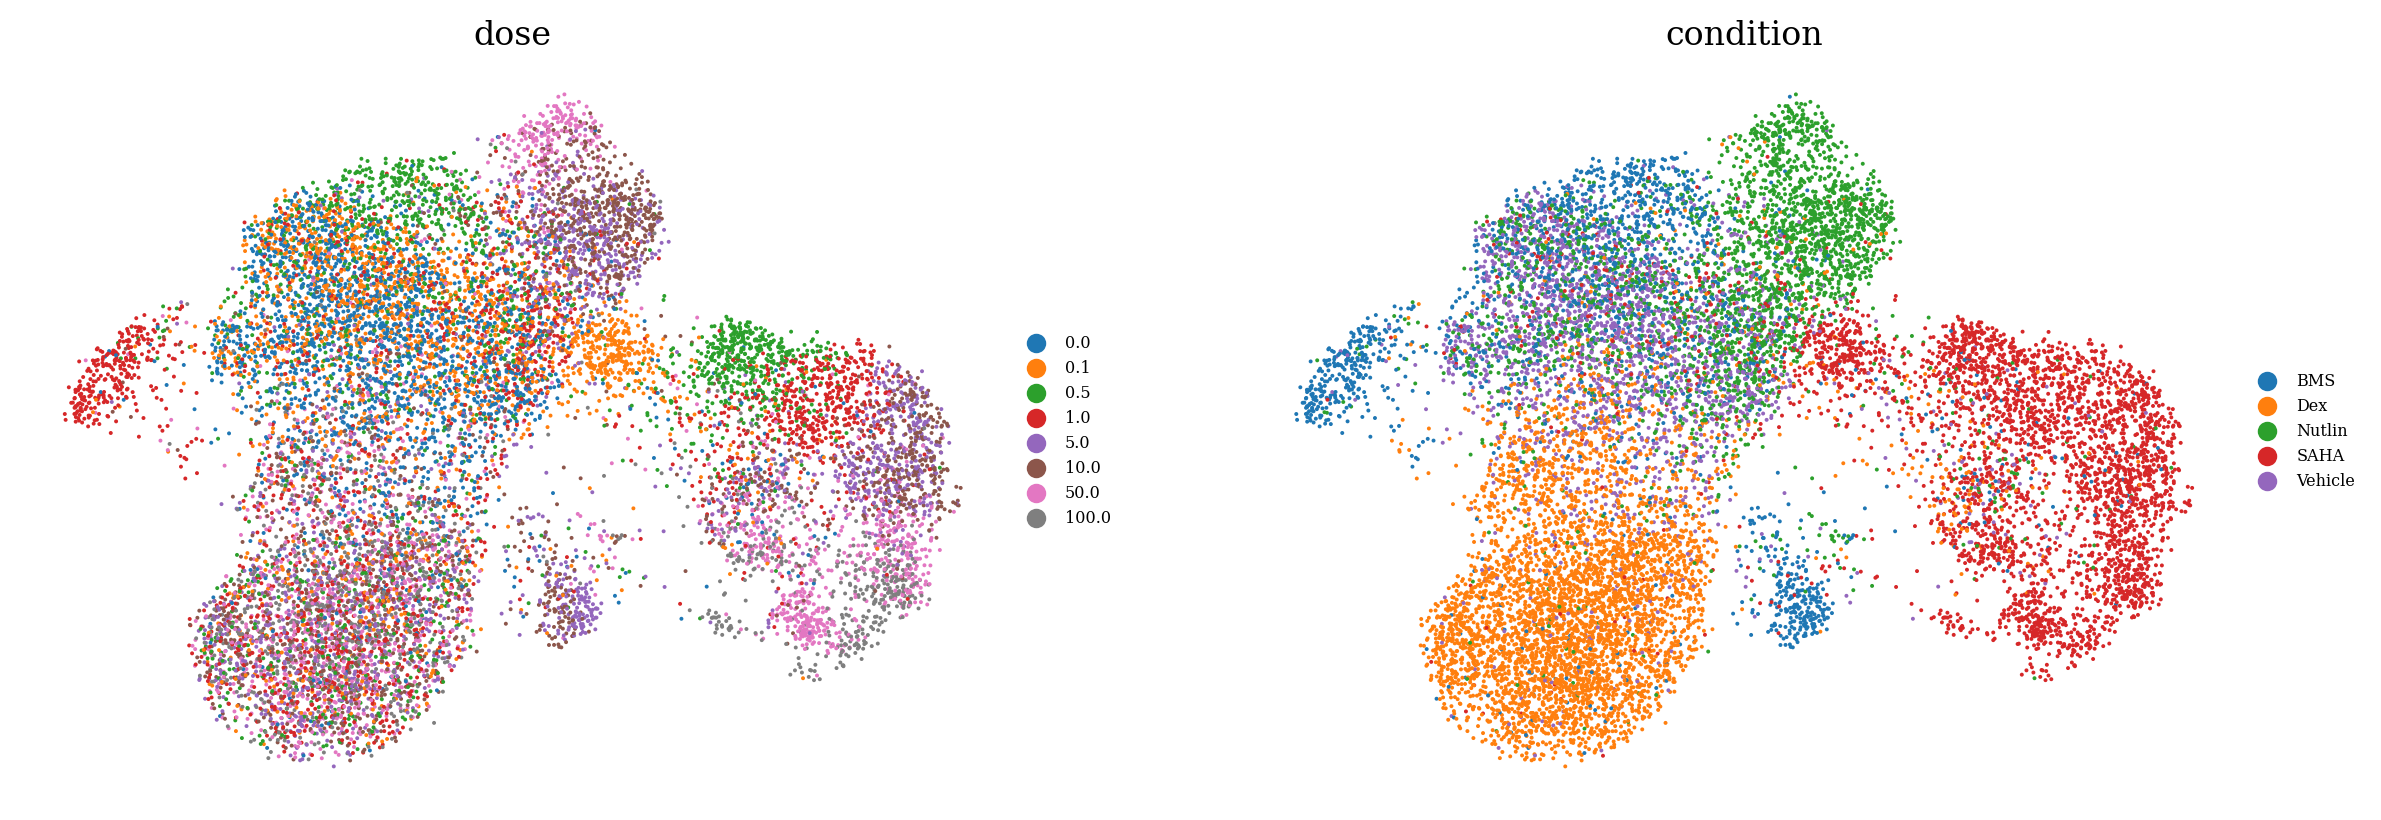

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

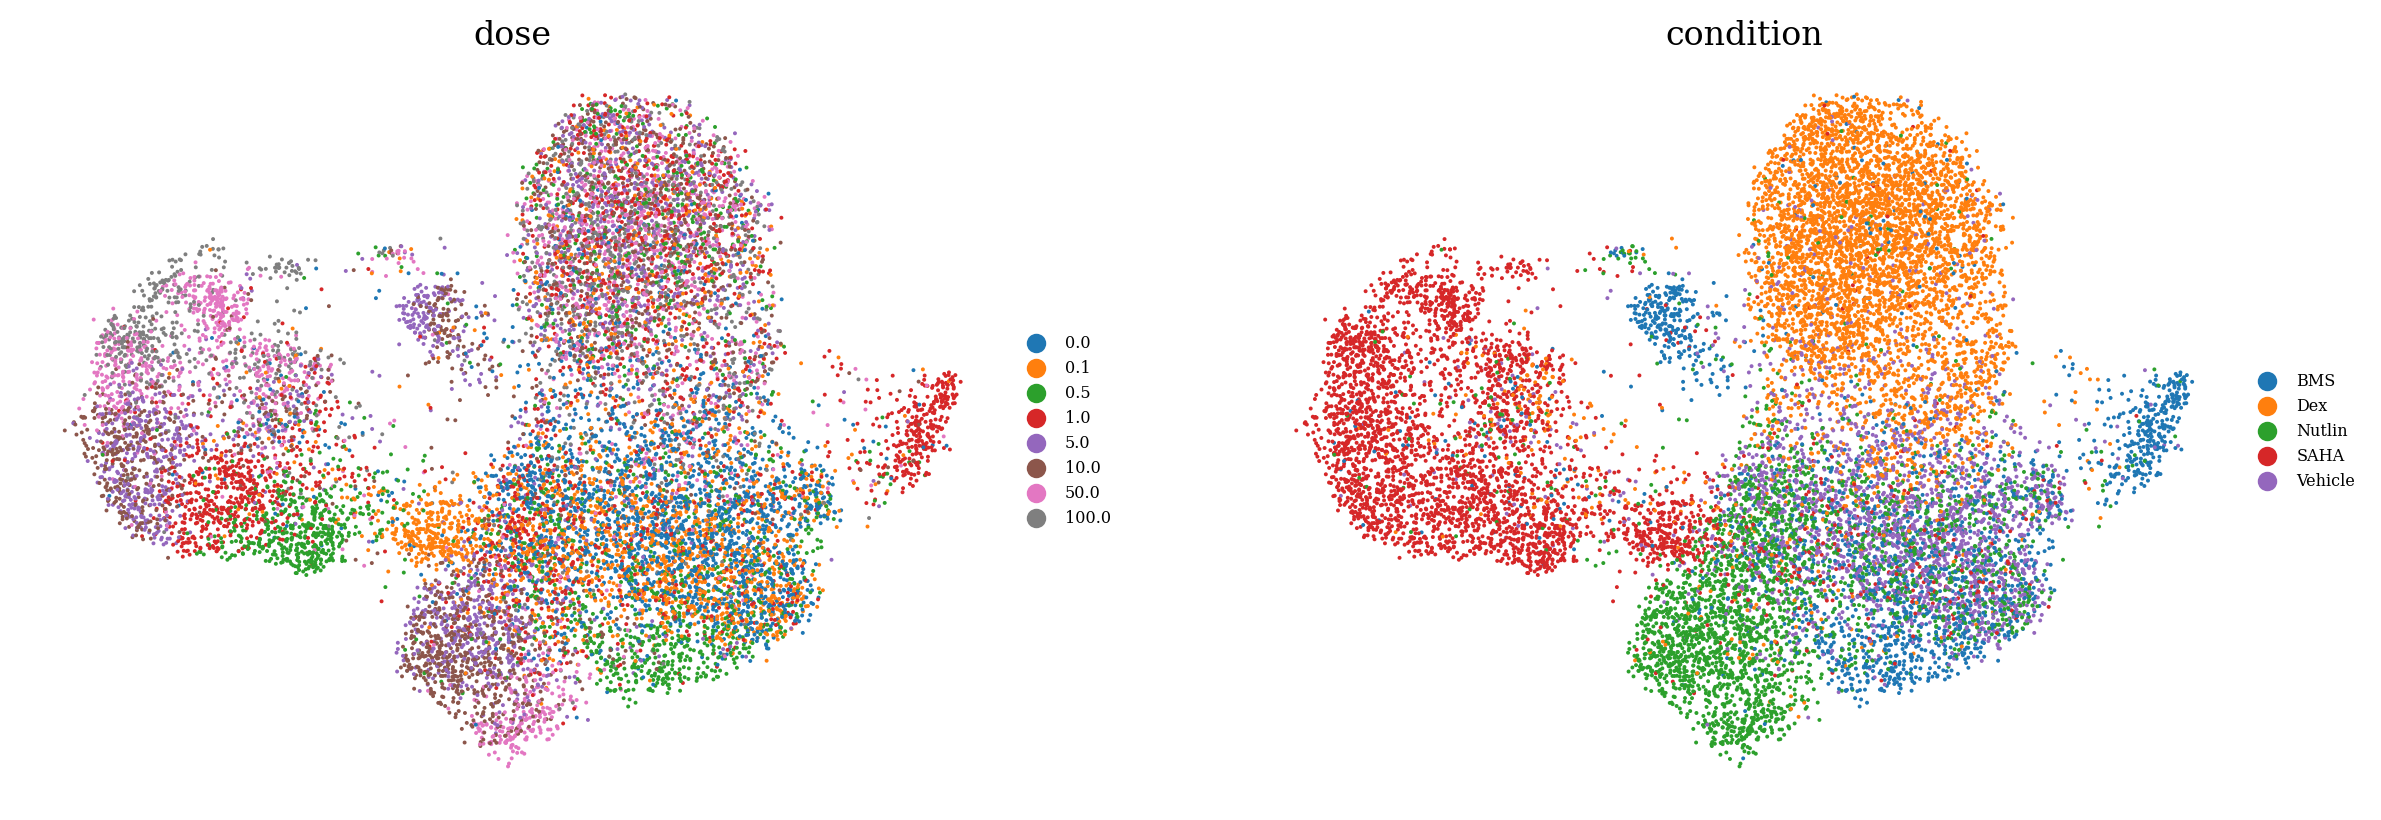

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<01:25,  5.42it/s]

  5%|▍         | 22/463 [00:00<00:04, 94.66it/s]

 10%|▉         | 45/463 [00:00<00:02, 146.50it/s]

 15%|█▍        | 68/463 [00:00<00:02, 174.70it/s]

 20%|█▉        | 91/463 [00:00<00:01, 191.80it/s]

 25%|██▍       | 114/463 [00:00<00:01, 202.61it/s]

 30%|██▉       | 137/463 [00:00<00:01, 210.14it/s]

 35%|███▍      | 160/463 [00:00<00:01, 214.77it/s]

 40%|███▉      | 183/463 [00:00<00:01, 218.14it/s]

 44%|████▍     | 206/463 [00:01<00:01, 133.69it/s]

 49%|████▉     | 229/463 [00:01<00:01, 153.05it/s]

 54%|█████▍    | 250/463 [00:01<00:01, 164.67it/s]

 58%|█████▊    | 270/463 [00:01<00:01, 108.33it/s]

 63%|██████▎   | 293/463 [00:01<00:01, 129.70it/s]

 68%|██████▊   | 316/463 [00:02<00:00, 149.47it/s]

 73%|███████▎  | 338/463 [00:02<00:00, 163.93it/s]

 78%|███████▊  | 361/463 [00:02<00:00, 178.76it/s]

 83%|████████▎ | 383/463 [00:02<00:00, 188.04it/s]

 88%|████████▊ | 406/463 [00:02<00:00, 197.93it/s]

 93%|█████████▎| 429/463 [00:02<00:00, 205.61it/s]

 98%|█████████▊| 452/463 [00:02<00:00, 211.29it/s]

100%|██████████| 463/463 [00:02<00:00, 169.11it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9625278295558413

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)